# Part 1: Core Attention Mechanism Demo

Building the core calculation flow of Self-Attention from scratch ($Q, K, V$ and dimension operations).

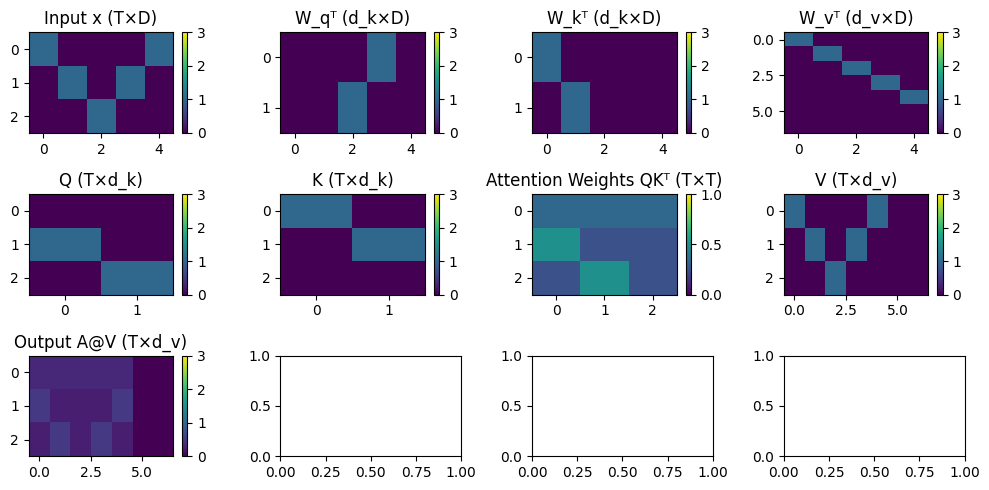

In [ ]:
import torch
import math
import matplotlib.pyplot as plt

#Recreate the prime-number self-attention example

x = torch.tensor(
    [[1.0, 0.0, 0.0, 0.0, 1.0],
     [0.0, 1.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 1.0, 0.0, 0.0]]
)

d_model = 5
d_k = 2
d_v = 7

W_q = torch.tensor(
    [[0.0, 0.0],
     [0.0, 0.0],
     [0.0, 1.0],
     [1.0, 0.0],
     [0.0, 0.0]]
)


W_k = torch.tensor(
    [[1.0, 0.0],
     [0.0, 1.0],
     [0.0, 0.0],
     [0.0, 0.0],
     [0.0, 0.0]]
)

W_v = torch.tensor(
    [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]]
)

Q = x @ W_q
K = x @ W_k
V = x @ W_v

attn_logits = Q @ K.T
scaled_logits = attn_logits / math.sqrt(d_k)
attn_weights = torch.softmax(scaled_logits, dim=-1)
attn_output = attn_weights @ V

# W_o = torch.rand((7, 5))
# final_output = attn_output @ W_o

# Plotting

mats = [
    (x,          "Input x (T×D)"),
    (W_q.T,      "W_qᵀ (d_k×D)"),
    (W_k.T,      "W_kᵀ (d_k×D)"),
    (W_v.T,      "W_vᵀ (d_v×D)"),
    (Q,          "Q (T×d_k)"),
    (K,          "K (T×d_k)"),
    (attn_weights, "Attention Weights QKᵀ (T×T)"),
    (V,          "V (T×d_v)"),
    (attn_output, "Output A@V (T×d_v)"),


    # (final_output, "Final Output (T×D)")
]

fig, axes = plt.subplots(3, 4, figsize=(10, 5))
axes = axes.flatten()

for ax, (mat, title) in zip(axes, mats):
    vmax = 1 if "Attention Weights" in title else 3
    im = ax.imshow(mat, aspect="auto", vmin=0,vmax=vmax,cmap="viridis")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


In [ ]:
import torch

Starting by generating some test data to play around with - generating 1000 data points, each data point will be a sequence of 40 vectors, each vector of length 10.

Notice that we are doing batch-first encoding here, so X[n] is sequence n, and X[n,:,t] is the full t-th vector of sequence n.

In [ ]:
X = torch.randn( (1000, 10, 40) )

In [ ]:
X.shape

torch.Size([1000, 10, 40])

We are going to need to multiply each vector in each sequence by a weight matrix. The weight matrix will need to have 10 columns (for multiplication to make sense), and I'm setting the number of rows here as 7 to give us an obviously distinct number.

In [ ]:
W = torch.randn( (7,10) )

In [ ]:
mat_product = torch.matmul( W, X )

In [ ]:
mat_product.shape

torch.Size([1000, 7, 40])

Notice that pytorch has handled the matrix multiplication mechanics for us, automatically applying the [4 x 10] matrix W to each of the 1,000 sequences of size [10 x 40] (broadcasting), giving us 1,000 sequences, each of size [7 x 40]

Note, we can use the convenient shorthand operator: @

In [ ]:
mat_product = ( W @ X )

In [ ]:
mat_product.shape

torch.Size([1000, 7, 40])

So in an attention module, we would need to specify three weight matrices: Wq, Wk, Wv

Note that each should have columns equal to the vector dimension of the terms of X, but they can have variable row counts. The only requirement is that the rows of Wq (query dimension) must match the rows of Wk (key dimension)

In [ ]:
d_embed = 10
d_qk = 7
d_v = 5

In [ ]:
Wq = torch.randn( (d_qk, d_embed ) )
Wk = torch.randn( (d_qk, d_embed) )
Wv = torch.randn( (d_v, d_embed) )

In [ ]:
Q = (Wq @ X)
K = (Wk @ X)
V = (Wv @ X)

In [ ]:
Q.shape

torch.Size([1000, 7, 40])

In [ ]:
K.shape

torch.Size([1000, 7, 40])

In [ ]:
V.shape

torch.Size([1000, 5, 40])

To calculate the attention weights, we first need to compute the dot product of every query vector with every key vector, which will give us (for each of the 1000 data points) a 40x40 matrix (based on every possible q,k pair for that sequence)

In [ ]:
( Q @ torch.transpose(K, dim0 = 1, dim1 = 2) ).shape

torch.Size([1000, 7, 7])

These dimensions always give me a headache... Note that when I was giving this in class, I described a sequence in terms of having ( length rows x dimension columns ) which is actually the transpose of what PyTorch expects if we're doing batch first encoding! This is why I think it is important to go through the dimension calculations carefully here.

Q = [ 1000 x 7 x 40 ]
K = [ 1000 x 7 x 40 ]

Because of the way this is batched, we want to swap the dimensions of Q (transpose in the last two dimensions)

Q^T = [ 1000 x 40 x 7 ] (this matches the layout of Q that I was giving in class )

K = [ 1000 x 7 x 40 ]

So batch multiplying ( Q^T @ K ) will give us the 40x40 square we need.


In [ ]:
torch.transpose(K, dim0 = 1, dim1 = 2).shape

torch.Size([1000, 40, 7])

In [ ]:
( ( torch.transpose(Q, dim0 = 1, dim1 = 2) @ K ).shape )

torch.Size([1000, 40, 40])

In [ ]:
attention_logits = torch.transpose(Q, dim0 = 1, dim1 = 2) @ K

To get the attention weights, we need to softmax across the rows

Note that this works out, since the first row of Q.transpose here is our first query vector q(0)

So the first row of the product Q.transpose @ K will be each vector in the K-sequence dotted with q(0)

(Feel free to draw a picture if it helps!)

In [ ]:
attention_weights = torch.nn.Softmax( dim = 2 )( attention_logits )

In [ ]:
attention_weights.shape

torch.Size([1000, 40, 40])

In [ ]:
torch.sum( attention_weights[ 0, 0, : ] )

tensor(1.)

Summing over each entry in the first row (going across the columns in dim=2) gives us 1, as it should.

The last step, we need to multiply by V to get the total attention summary

attention = [ 1000 x 40 x 40 ]
V = [ 1000 x 5 x 40 ]

In [ ]:
Y = ( V ) @ torch.transpose( attention_weights, dim0 = 1, dim1 = 2 )

In [ ]:
Y.shape

torch.Size([1000, 5, 40])

And there we have it.

Note that in the original paper, attention logits are also scaled by the square root of the embedded dimension d_qk, so that the dot products don't get too large.

We can bring this all together into an attention head module.

# Part 2: Attention Modularity & Hybrid Architecture

Encapsulating the Attention mechanism into a reusable module and combining it with an RNN for the "Dracula" problem.

In [ ]:
import numpy as np

In [ ]:
class Attention_Head_From_Scratch(torch.nn.Module):
  def __init__(self, d_qk, d_v, d_embed):
    super(Attention_Head_From_Scratch, self).__init__()

    self.Wq = torch.nn.Parameter( torch.randn( ( d_qk, d_embed ) ) , requires_grad = True )
    self.Wk = torch.nn.Parameter( torch.randn( ( d_qk, d_embed ) ) , requires_grad = True )
    self.Wv = torch.nn.Parameter( torch.randn( ( d_v, d_embed ) ) , requires_grad = True )

    self.d_qk = d_qk

  def forward(self, X ):

    Q = (self.Wq @ X)
    K = (self.Wk @ X)
    V = (self.Wv @ X)

    # shorter version: attention_logits = Q.transpose(1, 2) @ K
    attention_logits = torch.transpose(Q, dim0 = 1, dim1 = 2) @ K

    attention_logits /= np.sqrt( self.d_qk )

    attention_weights = torch.nn.Softmax( dim = 2 )( attention_logits )

    Y = ( V ) @ torch.transpose( attention_weights, dim0 = 1, dim1 = 2 )

    return Y

In [ ]:
attention_head = Attention_Head_From_Scratch( d_qk = 7, d_v = 5, d_embed = 10 )

In [ ]:
Y = attention_head( X )

In [ ]:
Y.shape

torch.Size([1000, 5, 40])

Nice. At this point, we can use this as a sub-module in a larger computation. If we return to the Dracula example:

In [ ]:
class Token_Attention_Model(torch.nn.Module):
  def __init__(self, token_dictionary, embedding_size):
    super(Token_Attention_Model, self).__init__()

    self.tokens = token_dictionary
    self.embedding_dim = embedding_size

    self.embedding = torch.nn.Embedding( len( self.tokens ), self.embedding_dim, max_norm=True)

    self.attention_head = Attention_Head_From_Scratch( d_qk = embedding_size, d_v = embedding_size, d_embed = embedding_size )

    self.rnn = torch.nn.RNN(input_size = 2 * self.embedding_dim,
                              hidden_size = 3 * self.embedding_dim,
                              num_layers=1,
                              bias=True,
                              batch_first = True,
                              dropout=0.0,
                              bidirectional=False)

    self.logits = torch.nn.Linear(in_features = 3*self.embedding_dim, out_features = len( self.tokens ) )

  def forward(self, input_tensor):
    #############################################

    batch_size, seq_length = input_tensor.shape

    ############################################

    embedded = self.embedding( input_tensor )

    #print( embedded.shape )

    attended = self.attention_head( torch.transpose( embedded, dim0 = 1, dim1 = 2 ) )
    attended = torch.transpose( attended, dim0 = 1, dim1 = 2 )


    #print( embedded.shape, attended.shape )
    concatenated = torch.concat( ( embedded, attended), dim = 2 )


    #print( concatenated.shape )

    seq_output, last_states = self.rnn( concatenated )

    output = last_states[0]

    output = self.logits( output )

    return output

# Part 3: Data Preparation & Training Pipeline

Scraping text data, creating a token dictionary, generating training batches, and executing the training loop.

In [ ]:
import random
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import bs4
import urllib.request

In [ ]:
webpage = str(urllib.request.urlopen("https://www.gutenberg.org/cache/epub/45839/pg45839.txt").read())
soup = bs4.BeautifulSoup(webpage)
text = soup.get_text()

text = text.replace("\\r\\n", '\n')

print(text[0:1000])

b'\xef\xbb\xbfThe Project Gutenberg eBook of Dracula
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are located
before using this eBook.

Title: Dracula

Author: Bram Stoker

Release date: May 30, 2014 [eBook #45839]
                Most recently updated: March 17, 2025

Language: English

Credits: Produced by Juliet Sutherland, Reiner Ruf, James Adcock
        and the Online Distributed Proofreading Team at
        http://www.pgdp.net


*** START OF THE PROJECT GUTENBERG EBOOK DRACULA ***

                          Transcriber\xe2\x80\x99s Note
                          ##################

This e-text is based on a reproduction

In [ ]:
tokens = list(set(text))
print( tokens )

['n', 'k', 'e', '/', '6', '9', 'o', 'g', '[', 'V', '(', 'W', ')', 'J', 'l', 't', 'B', 'H', 's', '0', "'", 'L', '#', 'X', 'x', 'I', '5', ' ', '{', '!', 'Q', '%', '7', '3', 'z', 'M', 'N', '.', '1', 'f', '}', '*', '&', 'i', 'r', 'c', 'h', 'q', 'E', 'C', 'U', 'y', 'T', '_', 'A', 'b', '$', 'a', 'v', '\\', 'j', '8', '?', 'O', '2', ';', 'F', '\n', 'p', 'P', 'w', 'u', 'R', 'G', '4', ':', ',', 'D', 'S', 'd', 'K', 'Y', 'Z', 'm', '-', ']']


In [ ]:
def generate_sample_token_sequence(text, sequence_length):
  start_point = random.randint(0, len( text ) - 1 - sequence_length - 1)
  # We want to get a sequence of length 'length', and the next character
  substring = text[start_point:start_point + sequence_length]
  next_token = text[start_point + sequence_length]

  return substring, next_token

generate_sample_token_sequence(text, 100)

('an\nsleep when those she loves are in danger! I shall lie down and pretend\nto sleep, lest Jonathan ha',
 'v')

In [ ]:
def generate_batch(text, length, batch_size, token_dict):
  x_index_lists = []
  y_index_list = []

  for i in range( batch_size ):
    substring, next_token = generate_sample_token_sequence( text, length )
    x_index_lists.append( [ token_dict.index( c ) for c in substring ]  )
    y_index_list.append( token_dict.index( next_token ))

  return torch.LongTensor(x_index_lists), torch.LongTensor(y_index_list)

In [ ]:
generate_batch(text, length = 10, batch_size = 5, token_dict = tokens)

(tensor([[ 7, 46, 27, 70, 46,  2, 44,  2, 27, 15],
         [ 0, 15, 76, 27, 39,  6, 44, 27, 43, 15],
         [ 2, 79, 27, 68, 44,  6, 55, 57, 55, 14],
         [27, 55, 57, 45,  1, 27,  6, 58,  2, 44],
         [71, 15, 27, 43, 15, 27,  0,  6, 70, 37]]),
 tensor([ 6, 27, 51, 27, 27]))

In [ ]:
attention_model = Token_Attention_Model(tokens, 20)

In [ ]:
def predict_next_character(model, substring, tokens):
  indices = torch.LongTensor( [ [ tokens.index(c) for c in substring ] ] )
  next_token_logits = model( indices ).detach()[0]
  next_token_probabilities = torch.nn.Softmax( dim = 0 )( next_token_logits )
  next_token_probabilities = np.asarray( next_token_probabilities )

  next_character = random.choices( tokens, weights = next_token_probabilities, k = 1 )
  return next_character[0]

def extend_prompt(model, prompt, tokens, character_count):
  model.eval()
  output = prompt
  with torch.no_grad():

    for i in range( character_count ):
      next_character = predict_next_character(model, output, tokens)
      output += next_character
  return output

In [ ]:
extend_prompt( attention_model, "Dracula flew", tokens, 40)

'Dracula flew*a6ve2{DE\n.W,G\nR.qL7\n}0-B)-5]_JDZ3)E\nIcU'

In [ ]:
attention_model = Token_Attention_Model(tokens, 30)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam( attention_model.parameters(), lr = 0.001 )

In [ ]:
batch_size = 16

for epoch in range(10):
  total_loss = 0
  print("Training Epoch", epoch)
  print()

  attention_model.train()

  for batch in range( 100 ):
    seq_length = random.randint(1,30)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    optimizer.zero_grad()
    logits = attention_model( x_batch )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print("########################################################")
  print( extend_prompt(attention_model, "The Count", tokens, 500) )
  print( total_loss / ( 100 ))
  print("########################################################")

Training Epoch 0

########################################################
The Countdaahs  laroderhned nef;e
eelnesx d-e 
sh ttvearinneper ahucedo me neamstx)nesaed
relelw is\. l0e t e  x eupbns-u as 
atitt8 tdyc apt a,s_ho\Ss\Teen dx t
a
iae\brxe-\O9h
aeho nuaow psd ms hIetcthyttn3lec disctondllevne! isae  dasoneasse eaeTpaeM c9er -np}f a or l9lac0\e w osu-eyt
nattper dl bhnam Ml0od 
.eanwrStaeiitnke deip t hera  anehtkis a
 
hnonle se
sa e dx\-xerfyeeaa aH e ntpinleeVi a\e thvbe ve iatseada eumce. qsF,iltzxdel9sleeei ero,t rMnetenlcas it espdn xc dehp iass?ertwlorthwolsue. oo
3.428877375125885
########################################################
Training Epoch 1

########################################################
The Counte wh Goohdec oaaivninuime sndiumetr Sstl wdintxt\aoyinnotbeeitiak
 s tre0s \0eraiIhem tdf easuw ned \hlaaid 9nd i  td v-ueeeihed hof9d  o!
xekoths ritsrg olnW he tue slmp
mn uome dge. b tde asa msh.oneioe.alf
tHne huwv are hi otoii, YhivienirefaohotWe ngot

In [ ]:
batch_size = 16

for epoch in range(20):
  total_loss = 0
  print("Training Epoch", epoch)
  print()

  attention_model.train()

  for batch in range( 100 ):
    seq_length = random.randint(1,30)
    x_batch, y_batch =  generate_batch(text, seq_length, batch_size, tokens)
    optimizer.zero_grad()
    logits = attention_model( x_batch )
    loss = loss_function( logits, y_batch )
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print("########################################################")
  #print( extend_prompt(attention_model, "The Count", tokens, 500) )
  print( total_loss / ( 100 ))
  print("########################################################")

Training Epoch 0

########################################################
2.1464806461334227
########################################################
Training Epoch 1

########################################################
2.1965115106105806
########################################################
Training Epoch 2

########################################################
2.1065949356555937
########################################################
Training Epoch 3

########################################################
2.1275812005996704
########################################################
Training Epoch 4

########################################################
2.195660231113434
########################################################
Training Epoch 5

########################################################
2.1648195672035215
########################################################
Training Epoch 6

########################################################
2.170610326528549
##

In [ ]:
extend_prompt(attention_model, "The Count", tokens, 500)

'The Count of this wared heaz thingeelatidg lyear.\\xe2\\x80\\x9csslet the hak meel,. Ame he?\\xe2\\x80\\x9cMmen so lfobs. I wute ont I tufl y ti himelest She can thin we toor, a stradsbroks, tralp: sullingh siver at asle, mow\\xe2\\x80\\x92\\x80\\x99s\nboxf.---\n\\x80\\x9d\\xe2\\x80\\x9d tme afsle3 the aid wit thich hee aorued.\n\nfnoks thould.\n\nI was po wanate an to miveir, bellse br exed anouge ary a sirk therablapathey I Gole caguthan a fom gith\\xe2\\x80\\x9cwith of ban that Gut? I hif sood heen it plead hime\nwat the sel\\x'

# Part 4: Extra Feature: Positional Encoding

Provides the implementation for standard Positional Encoding (as a foundation for introducing the full Transformer).

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)